In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.ner_metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.ref_book import ReferenceBookAnonymization

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
set_seed(42)

2024-06-13 17:14:12.800378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученаая на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на анонимизированном с помощью справочников наборе данных i2b2 2014 без учёта регистра
    6. Version 5 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2014 без учёта регистра, GPT2 обучено на тренировочном наборе данных i2b2 2014 
    7. Version 6 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, GPT2 обучено на тренировочном наборе данных i2b2 2014 
    8. Version 7 --- обученная на нетронутом валидационном наборе данных i2b2 2014 без учёта регистра

### Этап 1: Сравнение результатов на наборе данных i2b2 2014
Сравнение будет включает в себя измерение метрик Recall, Precision и $F_1$ score для следующий моделей:
* BERT-base-cased
* BERT-base-uncased
* BERT-large-cased
* BERT-large-uncased
* BERT-large-uncased, но тренировочная и валидационная выборки поменяны местами

#### BERT-base-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

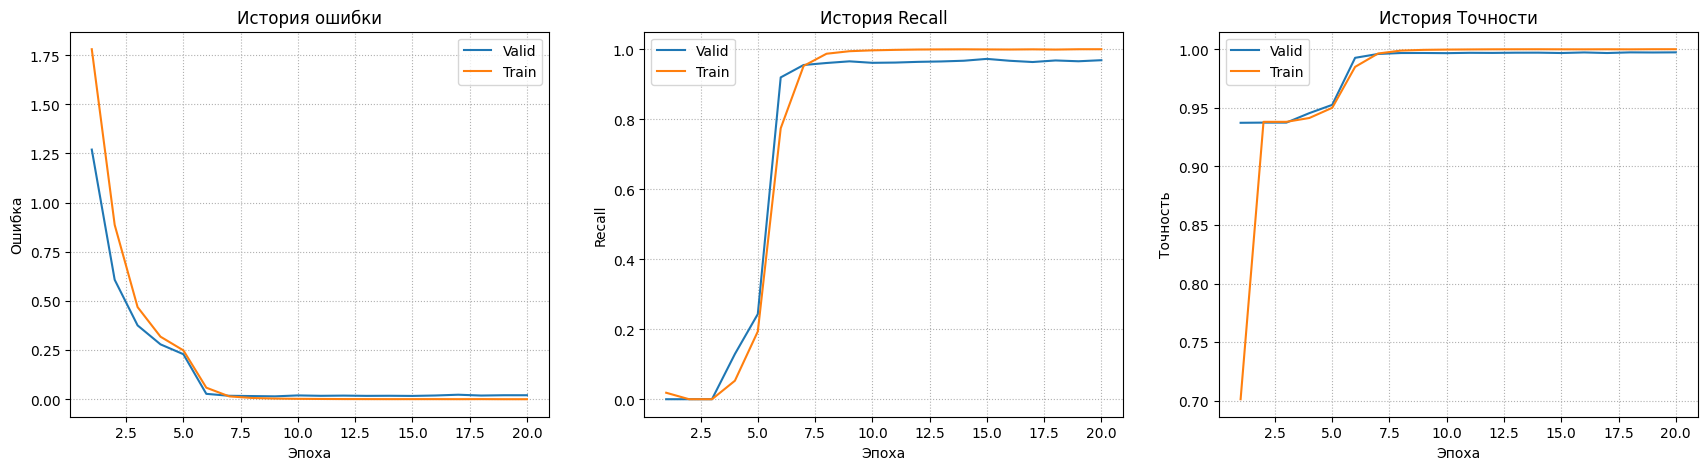

In [7]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(2)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [8]:
# Data processing
test_dataset = get_ner_dataset(dataset_type=i2b2_2014_data_config['dataset_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer="bert-base-cased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1382 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(2)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

Uniting records: 100%|██████████| 514/514 [00:00<00:00, 815.74it/s]


              precision    recall  f1-score   support

        NAME     0.9831    0.9675    0.9753     10661
  PROFESSION     0.9485    0.8165    0.8776       496
    LOCATION     0.8981    0.9309    0.9142      6005
         AGE     0.9518    0.9783    0.9649       828
        DATE     0.9969    0.9943    0.9956     21929
          ID     0.9655    0.9777    0.9716      3582
     CONTACT     0.9648    0.9721    0.9684      1184

   micro avg     0.9752    0.9752    0.9752     44685
   macro avg     0.9584    0.9482    0.9525     44685
weighted avg     0.9756    0.9752    0.9753     44685



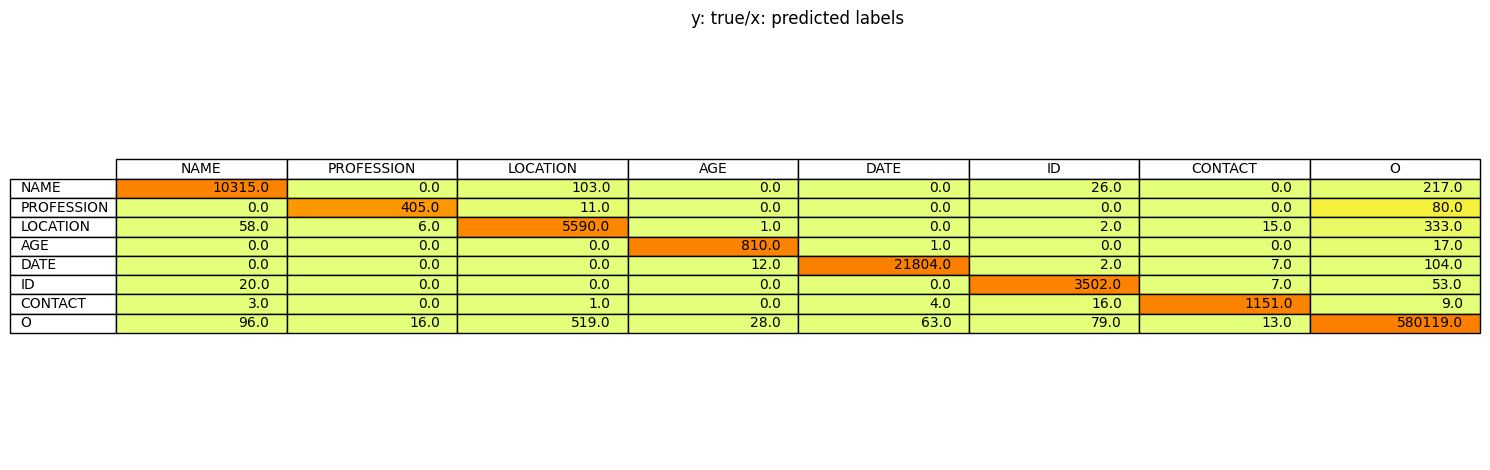

Wrongly predicted examples:
_____ Record 168-02 _____
| Sentence:    | Record date : | 2073 - 03 - 25 | THE SPECIALTY HOSPITAL OF AUSTIN | CLINIC NOTE | Victor Lujan | SMH      | # : | 018 - 92 - 33 | March 25, 2073 | DIAGNOSIS : Bilateral hand numbness and pain, recurrent carpal tunnel syndrome. SUBJECTIVE : The patient is a | 54  | - year - old right - hand dominant male with multiple medical problems including diabetes mellitus and renal failure requiring hemodialysis, who was has had bilateral hand numbness for several years, but getting worse within the last year or so. The patient states that he has had past carpal tunnel release and trigger finger release of the bilateral hand and the symptoms that he is feeling now is somewhat similar 2 - 10 years ago appearance of symptoms. PAST MEDICAL HISTORY : Hypertension, diabetes mellitus, and chronic renal failure. PAST SURGICAL HISTORY : Bilateral eye surgeries, right shoulder surgeries, and bilateral carpal tunnel surgery as mentioned

In [11]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-base-uncased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

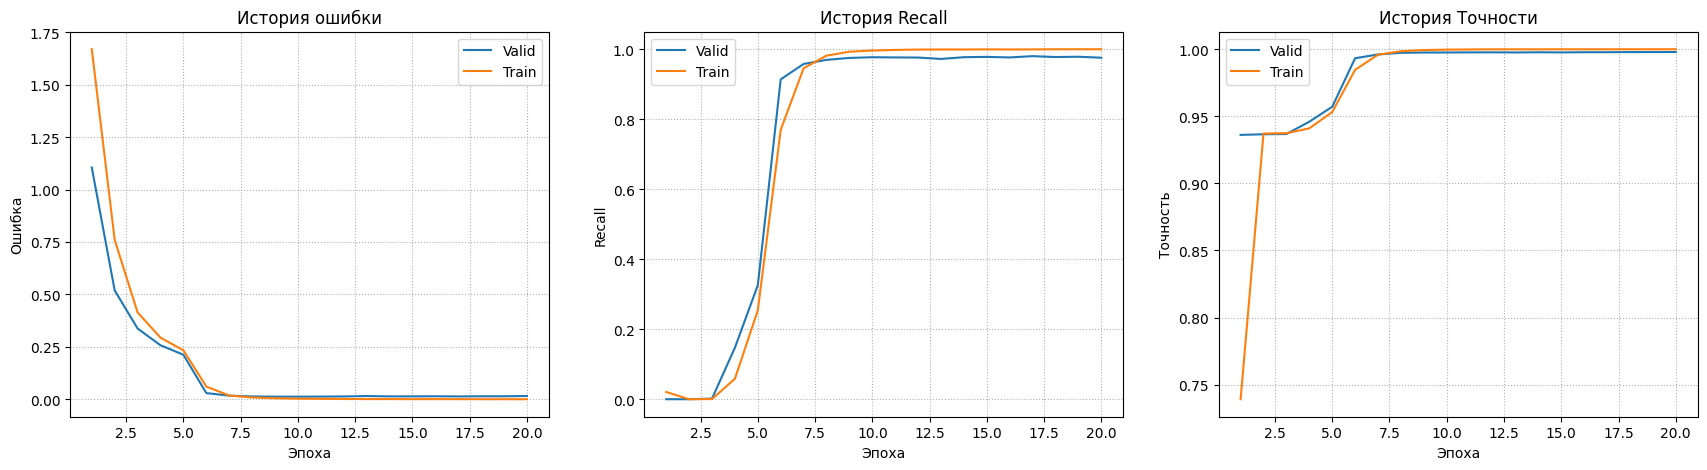

In [12]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(3)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [13]:
# Data processing
test_dataset = get_ner_dataset(dataset_type=i2b2_2014_data_config['dataset_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer="bert-base-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [14]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(3)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

Uniting records: 100%|██████████| 514/514 [00:00<00:00, 935.45it/s]


              precision    recall  f1-score   support

        NAME     0.9829    0.9840    0.9834      8107
  PROFESSION     0.8981    0.8251    0.8601       406
    LOCATION     0.9492    0.9248    0.9368      4522
         AGE     0.9747    0.9782    0.9765       827
        DATE     0.9960    0.9960    0.9960     21905
          ID     0.9636    0.9823    0.9729      3452
     CONTACT     0.9690    0.9817    0.9753      1147

   micro avg     0.9833    0.9819    0.9826     40366
   macro avg     0.9619    0.9532    0.9573     40366
weighted avg     0.9832    0.9819    0.9825     40366



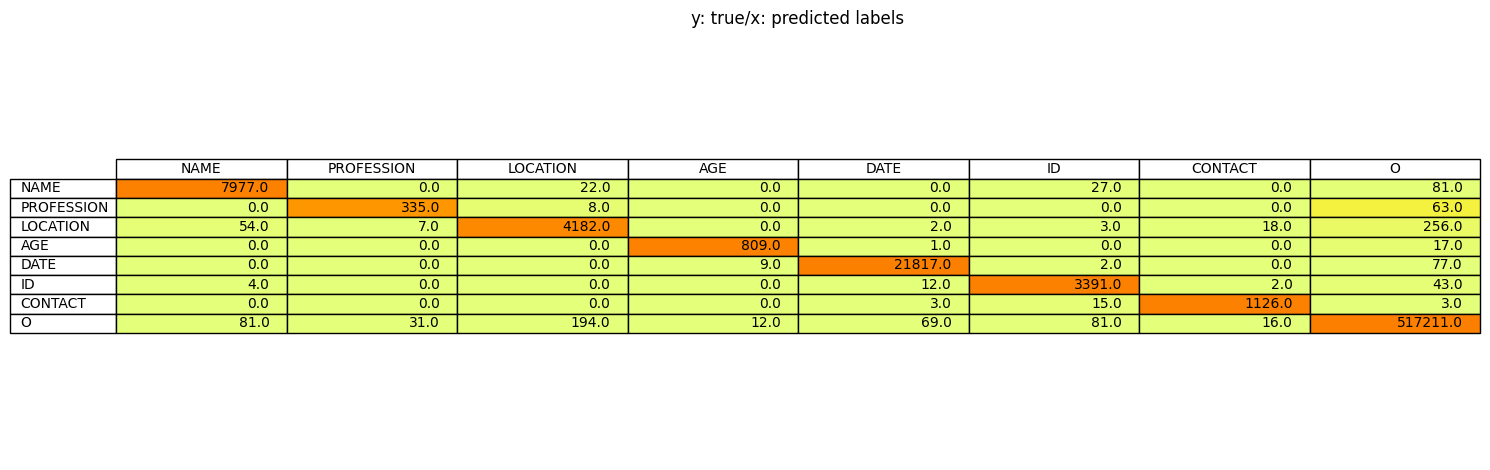

Wrongly predicted examples:
_____ Record 197-02 _____
| Sentence:    | record date : | 2096 - 12 - 29 | nmh      | gu | donn emery | nmh      | # : | 059 - 57 - 26 | december 29, 2096 | interval history : he has been troubled by increasing shortness of breath, which dr. | pina | , the physician covering for dr. | park | , thought might be related to asbestosis. he is to see her next on | january 15, 2097 | . review of systems : general : complaint of mild fatigue. no fevers, chills, or change in appetite. heent : no blurred vision, oral ulcers, lesions, thrush, neck swelling, neck stiffness, hoarseness. pulmonary : no cough, sob, doe, hemoptysis, wheezing. cardiac : no chest pain, palpitations. gastrointestinal : no nausea, vomiting, diarrhea, constipation, or abdominal pain. urologic : no dysuria, hematuria. lymph nodes : no enlarged lymph nodes. musculoskeletal : no back pain, neck pain, leg pain, or arm pain. hematologic : no bruising, bleeding or clotting. neurologic : the neuropat

In [16]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

Так как в изначальной статье подробно рассмотрено только предсказание модели BERT-base-uncased, в данной работе будет разобрана именно она.  
**Вывод:**  
Все классы кроме "PROFESSION" предсказываются с $Recall > 90\%$. Предположительно, это происходит из-за слабого представления класса в обучающей выборке (830 токенов). Для точности далее рассмотрены примеры ошибок его распознавания.  
Объявленную теорию также подтверждает точность предсказания класса 'CONTACT', который представлен хуже всех остальных классов кроме 'PROFESSION': такой же порядок сохраняется и в метрике Recall предсказния меток.  
Стоит отметить, что большинство ошибок модели связано не с путанием классов защищённых сущностей, а с их полным нераспознаванием.

In [17]:
faults = stats.get_specific_failed_predictions('PROFESSION')

Wrongly predicted examples:
_____ Record 212-01 _____
| Sentence:    | record date : | 2083 - 07 - 26 | internal medicine associates | san fernando hospital | reason for visit annual examination problem list ( reviewed ) diabetes mellitus major hypertension major myocardial infarction major status post pleural effusion major weight loss major health maintenance major pulmonary embolism major torticollis blindness congestive heart failure chronic renal insufficiency ventricular tachyarrhythmia major problems diabetes mellitus hypertension | 10 / 29 / 81 | = cont in good range, 120 / 80. p : check lyts, cr today on diuretic. myocardial infarction status post other problems chronic renal insufficiency ventricular tachyarrhythmia aicd. dr. | lacy | from | cch      | 7 / 26 / 83 | active medications nph insulin 8u hs dose will change - - started | 10 / 21 | qty : 1 bottle refills : 3 insulin syringes ultra fine insulin syringe 100 u - - - 1 box - - of 100 refills 3 ecotrin 325mg po qd prini

#### BERT-large-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

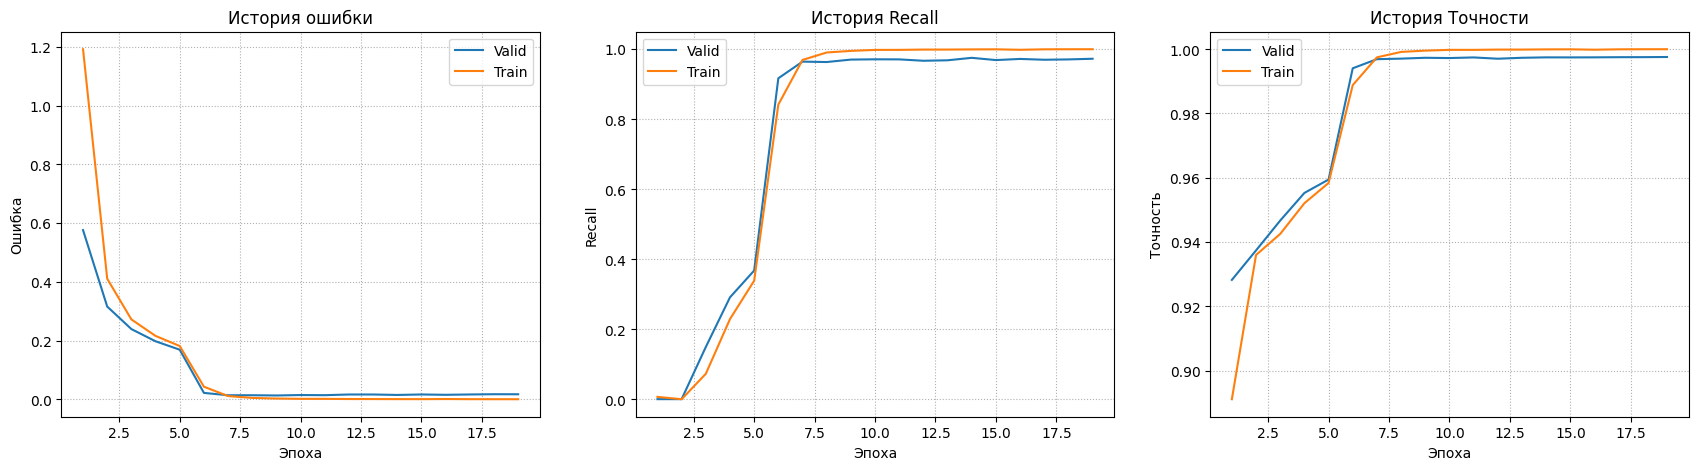

In [18]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(2)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [19]:
# Data processing
test_dataset = get_ner_dataset(dataset_type=i2b2_2014_data_config['dataset_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer="bert-large-cased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1382 > 512). Running this sequence through the model will result in indexing errors


In [20]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(2)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [ ]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

Uniting records: 100%|██████████| 514/514 [00:00<00:00, 796.87it/s]


              precision    recall  f1-score   support

        NAME     0.9835    0.9738    0.9786     10661
  PROFESSION     0.9775    0.8750    0.9234       496
    LOCATION     0.9461    0.9199    0.9328      6005
         AGE     0.9736    0.9795    0.9765       828
        DATE     0.9951    0.9944    0.9948     21929
          ID     0.9699    0.9816    0.9757      3582
     CONTACT     0.9629    0.9856    0.9741      1184

   micro avg     0.9824    0.9766    0.9795     44685
   macro avg     0.9727    0.9586    0.9651     44685
weighted avg     0.9823    0.9766    0.9794     44685



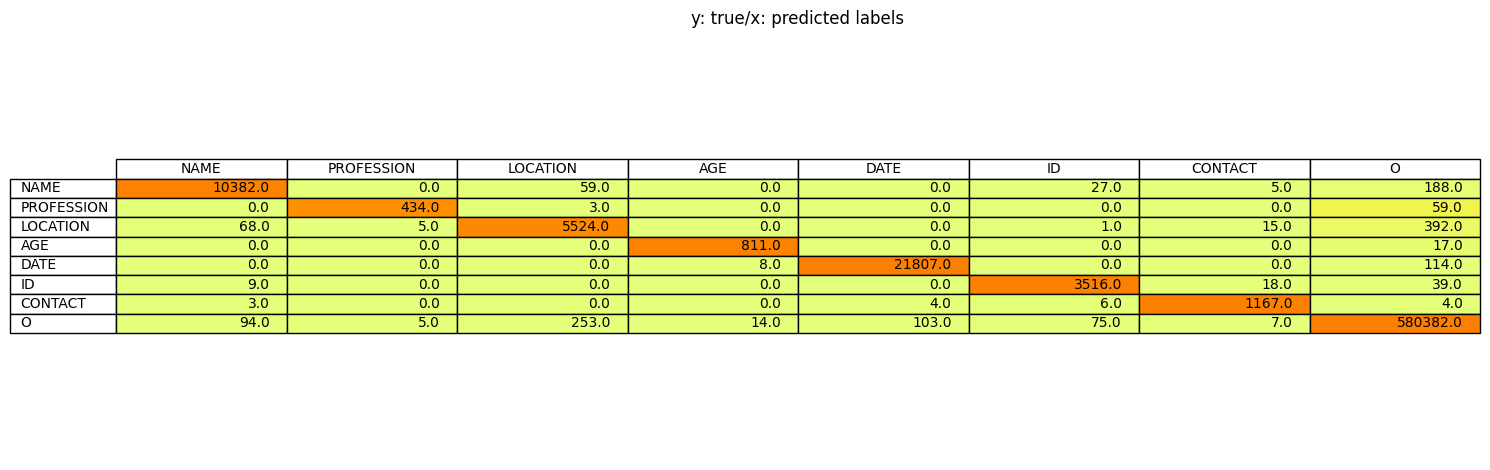

Wrongly predicted examples:
_____ Record 119-01 _____
| Sentence:    | Record date : | 2088 - 05 - 21 | Patient Name : | CURTIS, OM | ; MRN : | 7682941 | Dictated at : | 05 / 21 / 88 | by | VICTOR R. GOMES | , M. D. Mr. | Curtis | returns with a history of ureteral stones, BPH, and dysuria. He has not had any stone passage in the last six months. He has passed some tissue, and had some gross hematuria with his last visit, but has not had any symptoms since then. With his BPH, he has not had any significant worsening of his nocturia or daytime frequency. He feels as if he is emptying his bladder well now on the Cardura. He did have some dysuria, and Dr. | Geiger | gave him a pill which seems to have helped him. His review of systems today is negative. His past medical history is unchanged, and he is continuing with a cholesterol medication, a pill for burning, Cardura, and Atenolol. On physical examination, his vital signs show him to be well - nourished and well - developed. His respir

In [22]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-large-uncased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

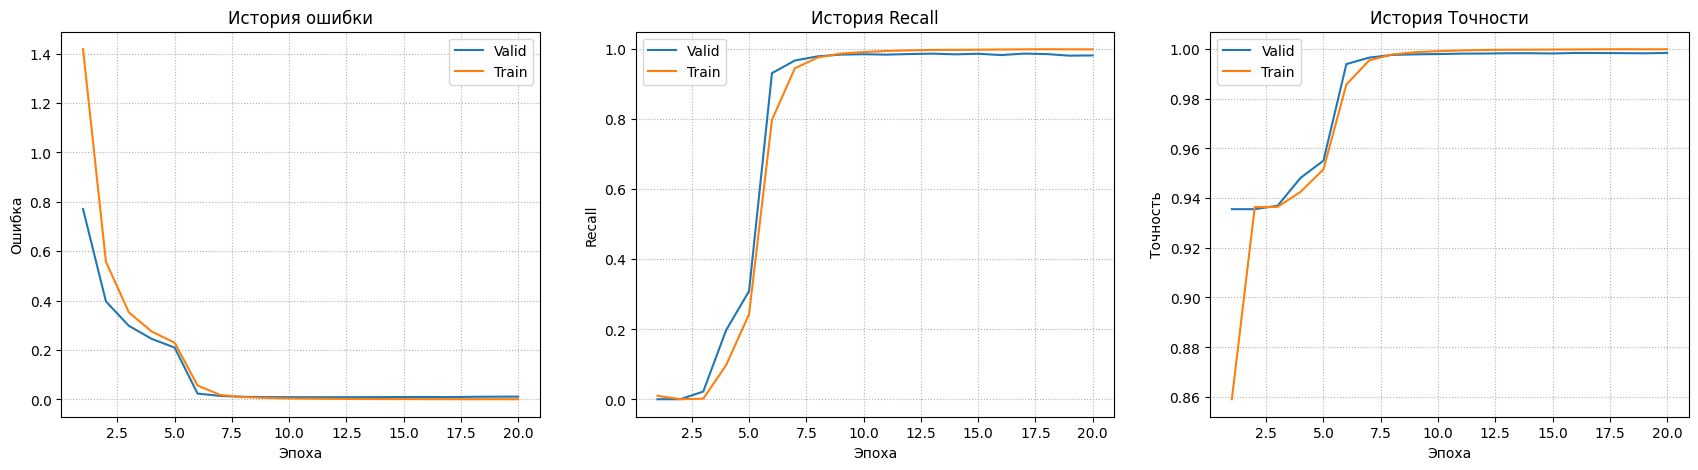

In [23]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(3)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [24]:
# Data processing
test_dataset = get_ner_dataset(dataset_type=i2b2_2014_data_config['dataset_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer="bert-large-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(3)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [ ]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

Computing predictions:   0%|          | 0/288 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Uniting records: 100%|██████████| 514/514 [00:00<00:00, 687.64it/s]


              precision    recall  f1-score   support

        NAME     0.9891    0.9853    0.9872      8107
  PROFESSION     0.9028    0.9384    0.9203       406
    LOCATION     0.9575    0.9617    0.9596      4522
         AGE     0.9794    0.9794    0.9794       827
        DATE     0.9973    0.9974    0.9973     21905
          ID     0.9778    0.9806    0.9792      3452
     CONTACT     0.9947    0.9817    0.9882      1147

   micro avg     0.9881    0.9881    0.9881     40366
   macro avg     0.9712    0.9749    0.9730     40366
weighted avg     0.9881    0.9881    0.9881     40366



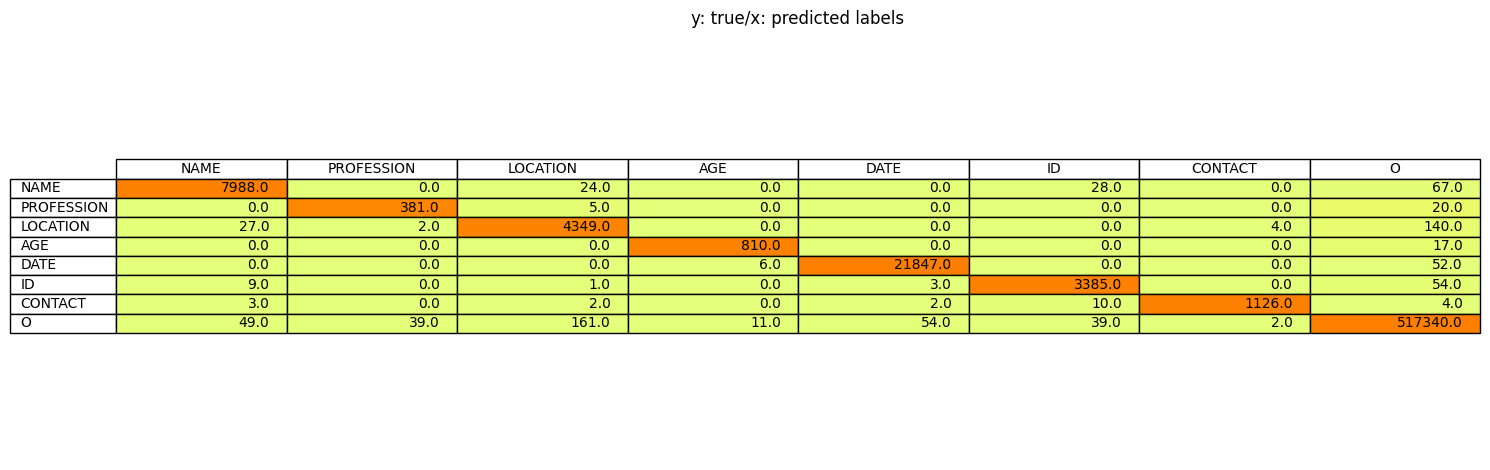

Wrongly predicted examples:
_____ Record 262-03 _____
| Sentence:    | record date : | 2091 - 12 - 16 | team d intern admission note patient name here : | olivo, kimberly | mr # | 3299811 | location : suite 53 - 02q date of admission : | december 15, 2091 | pcp : | isaac ng | id / cc : change in mental status hpi : | 70  | y / o female with pmhx significant for pituitary adenoma s / p resection, cryptogenic cirrhosis, presenting with confusion for the past 3 days. patient confused and unable to give history at time of admission. as per son and daughter, they have noticed increasing confusion and inappropriate behavior over the past 3 days. they report that she has woken up in the middle of the night c / o feeling weak and confused. the first two nights, her son treated her initially with increasing lactulose administration when she would wake up at night ( although it is unclear whether she had any increase in her stool ) and he reports that she would behave better during the day. on t

In [27]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-large-uncased, но тренировочная и валидационная выборки поменяны местами

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

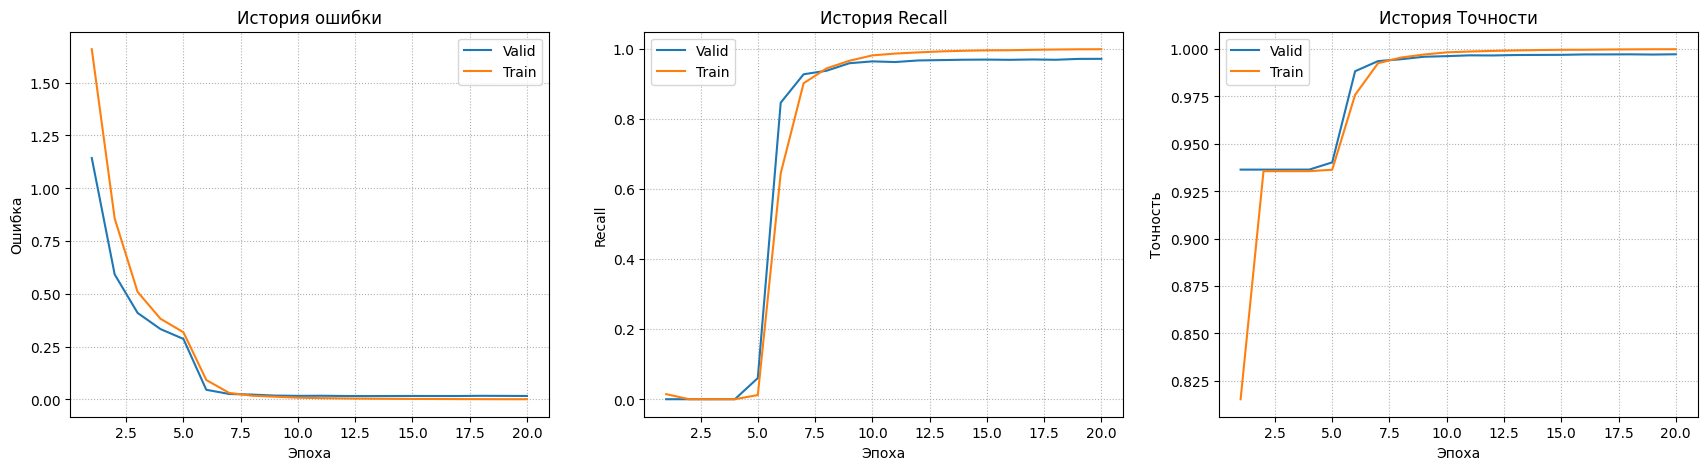

In [28]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(7)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [29]:
# Data processing
test_dataset = get_ner_dataset(dataset_type=i2b2_2014_data_config['dataset_type'],
                               path_to_folder=i2b2_2014_data_config["train_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer="bert-large-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [30]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(7)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [ ]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

Computing predictions:   0%|          | 0/448 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Uniting records: 100%|██████████| 790/790 [00:01<00:00, 736.21it/s]


              precision    recall  f1-score   support

        NAME     0.9831    0.9469    0.9647     12814
  PROFESSION     0.9295    0.8750    0.9014       512
    LOCATION     0.9455    0.9292    0.9373      7116
         AGE     0.9859    0.9530    0.9692      1320
        DATE     0.9936    0.9956    0.9946     33592
          ID     0.9503    0.9822    0.9660      4769
     CONTACT     0.9735    0.9452    0.9591      1514

   micro avg     0.9813    0.9736    0.9775     61637
   macro avg     0.9659    0.9467    0.9560     61637
weighted avg     0.9813    0.9736    0.9773     61637



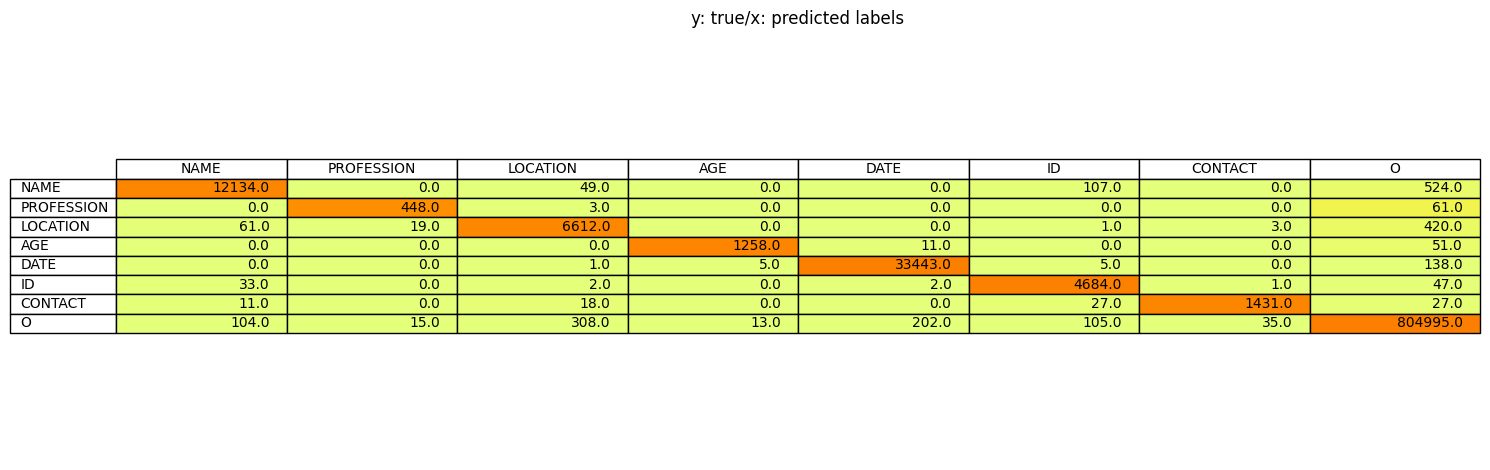

Wrongly predicted examples:
_____ Record 170-05 _____
| Sentence:    | record date : | 2150 - 09 - 28 | urology admission note as per dr. | nesmith | & # 8217 ; s note, detailed below, mr. | eubanks | is a | 69  | year - old male with nephrolithiasis. he underwent cystoscopy, selective cytologies, bilateral retrograde pyeloureterogram, left ureteroscopy, laser lithotripsy, stone extraction, stent, and bladder biopsies on | 9 / 27 / 50 | . post - operatively he experienced urinary retention and a catheter was placed without difficulty. he was advised he could safely return home, but he was sleepy and his wife expressed distress over looking after the catheter. he was therefore admitted. history of present illness : | 69  | yo male noted to have a 10mm distal left uvj stone during an evaluation for gross hematuria. no history of urinary tract infections and previous stones. past medical history : cad - cardiac stents x 3, gout, htn, hyperlipidemia, gerd, right ear surgery medications : a

In [32]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

**Вывод:**  
Recall предсказания класса превышает $98\%$ для всех меток кроме 'AGE' в свзязи с его малым представлением в выборке (51 токен). Самый низкая точность распознования среди остальных, классов касается метки 'LOCATION'. При этом стоит отметить, что хотя класс 'CONTACT' в обучающей выборке представлен хуже 'LOCATION', из-за фиксированного формата его записи модель распознает данный класс успешннее.